#### Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)


In [ ]:
products = pd.read_csv('amazon_baby_subset.csv')
products = products.fillna({'review':''})  # fill in N/A's in the review column
def remove_punctuation(text):
    import string
    return text.translate(text.maketrans('', '', string.punctuation))

products['review_clean'] = products['review'].apply(remove_punctuation)

important_words = list(pd.read_json('important_words.json')[0])

In [3]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

#### Train-Validation split

In [6]:
# split into train and test
# load the given data
trainidx = pd.read_json('module-4-assignment-train-idx.json')
trainidx[0] = trainidx[0] + 1 
validationidx  = pd.read_json('module-4-assignment-validation-idx.json')
validationidx[0] = validationidx[0] + 1 

train_data = pd.merge(trainidx, products, left_on=0, right_on=products.index)
validation_data = pd.merge(validationidx, products, left_on=0, right_on=products.index)

In [7]:
print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42361 data points
Validation set : 10710 data points


#### Convert data frame to multi-dimensional array

In [8]:
def get_numpy_data(data, features, label):
    data['intercept'] = 1
    features = ['intercept'] + features
    features_df = data[features]
    feature_matrix = features_df.to_numpy()
    label_series = data[label]
    label_array = label_series.to_numpy()
    return(feature_matrix, label_array)

In [9]:
# Warning: This may take a few minutes...

feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

#### Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [10]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-scores))
    
    # return predictions
    return predictions

#### Adding L2 Penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [11]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= (2 * l2_penalty * coefficient)
        
    return derivative

**Quiz Question:** In the code above, was the intercept term regularized? <br>
    No. 

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).
$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [13]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

**Quiz Question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?<br>
Decrease


The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [17]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

#### Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [18]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29182.04653002
iteration   1: log likelihood of observed labels = -29008.78655137
iteration   2: log likelihood of observed labels = -28841.96694138
iteration   3: log likelihood of observed labels = -28681.09005251
iteration   4: log likelihood of observed labels = -28525.76087961
iteration   5: log likelihood of observed labels = -28375.65056499
iteration   6: log likelihood of observed labels = -28230.47445606
iteration   7: log likelihood of observed labels = -28089.97888759
iteration   8: log likelihood of observed labels = -27953.93315450
iteration   9: log likelihood of observed labels = -27822.12455392
iteration  10: log likelihood of observed labels = -27694.35523509
iteration  11: log likelihood of observed labels = -27570.44011299
iteration  12: log likelihood of observed labels = -27450.20541072
iteration  13: log likelihood of observed labels = -27333.48757765
iteration  14: log likelihood of observed labels = -27220.1324

In [19]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29182.05017430
iteration   1: log likelihood of observed labels = -29008.80782659
iteration   2: log likelihood of observed labels = -28842.01876452
iteration   3: log likelihood of observed labels = -28681.18440702
iteration   4: log likelihood of observed labels = -28525.90891197
iteration   5: log likelihood of observed labels = -28375.86265925
iteration   6: log likelihood of observed labels = -28230.76029564
iteration   7: log likelihood of observed labels = -28090.34750897
iteration   8: log likelihood of observed labels = -27954.39299539
iteration   9: log likelihood of observed labels = -27822.68349718
iteration  10: log likelihood of observed labels = -27695.02064896
iteration  11: log likelihood of observed labels = -27571.21888812
iteration  12: log likelihood of observed labels = -27451.10399431
iteration  13: log likelihood of observed labels = -27334.51200486
iteration  14: log likelihood of observed labels = -27221.2883

In [20]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29182.05564074
iteration   1: log likelihood of observed labels = -29008.83973726
iteration   2: log likelihood of observed labels = -28842.09648879
iteration   3: log likelihood of observed labels = -28681.32591036
iteration   4: log likelihood of observed labels = -28526.13090124
iteration   5: log likelihood of observed labels = -28376.18069486
iteration   6: log likelihood of observed labels = -28231.18888443
iteration   7: log likelihood of observed labels = -28090.90018510
iteration   8: log likelihood of observed labels = -27955.08239284
iteration   9: log likelihood of observed labels = -27823.52141577
iteration  10: log likelihood of observed labels = -27696.01811490
iteration  11: log likelihood of observed labels = -27572.38620978
iteration  12: log likelihood of observed labels = -27452.45081352
iteration  13: log likelihood of observed labels = -27336.04734422
iteration  14: log likelihood of observed labels = -27223.0206

In [21]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)


iteration   0: log likelihood of observed labels = -29182.13763721
iteration   1: log likelihood of observed labels = -29009.31808750
iteration   2: log likelihood of observed labels = -28843.26084991
iteration   3: log likelihood of observed labels = -28683.44437276
iteration   4: log likelihood of observed labels = -28529.45222226
iteration   5: log likelihood of observed labels = -28380.93602883
iteration   6: log likelihood of observed labels = -28237.59321891
iteration   7: log likelihood of observed labels = -28099.15359196
iteration   8: log likelihood of observed labels = -27965.37114987
iteration   9: log likelihood of observed labels = -27836.01902765
iteration  10: log likelihood of observed labels = -27710.88624923
iteration  11: log likelihood of observed labels = -27589.77555770
iteration  12: log likelihood of observed labels = -27472.50188187
iteration  13: log likelihood of observed labels = -27358.89118473
iteration  14: log likelihood of observed labels = -27248.7795

In [22]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29182.95760195
iteration   1: log likelihood of observed labels = -29014.06971291
iteration   2: log likelihood of observed labels = -28854.75063942
iteration   3: log likelihood of observed labels = -28704.21271555
iteration   4: log likelihood of observed labels = -28561.80226691
iteration   5: log likelihood of observed labels = -28426.95666884
iteration   6: log likelihood of observed labels = -28299.17846938
iteration   7: log likelihood of observed labels = -28178.01954846
iteration   8: log likelihood of observed labels = -28063.07115641
iteration   9: log likelihood of observed labels = -27953.95739732
iteration  10: log likelihood of observed labels = -27850.33074308
iteration  11: log likelihood of observed labels = -27751.86876128
iteration  12: log likelihood of observed labels = -27658.27158677
iteration  13: log likelihood of observed labels = -27569.25986636
iteration  14: log likelihood of observed labels = -27484.5730

In [23]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29273.15372377
iteration   1: log likelihood of observed labels = -29273.01282940
iteration   2: log likelihood of observed labels = -29272.96275046
iteration   3: log likelihood of observed labels = -29272.91938970
iteration   4: log likelihood of observed labels = -29272.88020801
iteration   5: log likelihood of observed labels = -29272.84473061
iteration   6: log likelihood of observed labels = -29272.81260420
iteration   7: log likelihood of observed labels = -29272.78351215
iteration   8: log likelihood of observed labels = -29272.75716785
iteration   9: log likelihood of observed labels = -29272.73331176
iteration  10: log likelihood of observed labels = -29272.71170889
iteration  11: log likelihood of observed labels = -29272.69214641
iteration  12: log likelihood of observed labels = -29272.67443160
iteration  13: log likelihood of observed labels = -29272.65838996
iteration  14: log likelihood of observed labels = -29272.6438

#### Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [44]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
#table.index = table['word']
#del table['word']

In [45]:
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [46]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.077525,-0.076863,-0.075882,-0.062802,-0.006665,0.011098
1,baby,0.063113,0.063048,0.062953,0.061690,0.050830,0.001433
2,one,0.004630,0.004467,0.004227,0.001157,-0.008866,-0.001708
3,great,0.800742,0.795994,0.789003,0.700110,0.373961,0.008894
4,love,1.051008,1.043385,1.032168,0.890561,0.414915,0.008811
...,...,...,...,...,...,...,...
189,babies,0.030156,0.029997,0.029763,0.026796,0.014833,0.000249
190,won,0.003739,0.003700,0.003643,0.002914,0.000862,0.000015
191,tub,-0.225484,-0.223549,-0.220700,-0.184613,-0.069219,-0.001108
192,almost,-0.056926,-0.056400,-0.055625,-0.045699,-0.013706,-0.000207


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?<br>
'quality'

In [48]:
table[['word','coefficients [L2=0]']].sort_values('coefficients [L2=0]', ascending = False)[0:5]

,word,coefficients [L2=0]
23,loves,1.055057
4,love,1.051008
8,easy,0.990595
34,perfect,0.848576
3,great,0.800742


In [49]:
positive_words = table.sort_values('coefficients [L2=0]', ascending = False)[0:5]['word']
print(positive_words)

23      loves
4        love
8        easy
34    perfect
3       great
Name: word, dtype: object


In [50]:
negative_words = table.sort_values('coefficients [L2=0]', ascending = True)[0:5]['word']
print(negative_words)

106    disappointed
114          return
97            money
113           waste
169        returned
Name: word, dtype: object


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    
    table_positive_words = table.loc[table['word'].isin(positive_words)]
    table_negative_words = table.loc[table['word'].isin(negative_words)]
    
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

In [59]:
#make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])
#getting error in the above plot so not printing the plot

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.<br>
True

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)<br>
False

#### Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [61]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [62]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [63]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7857227166497486, validation_accuracy = 0.7840336134453781
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7856282901725644, validation_accuracy = 0.7839402427637722
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7853686173603078, validation_accuracy = 0.7838468720821662
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7838814003446566, validation_accuracy = 0.7830065359477124
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7731876018035457, validation_accuracy = 0.7743230625583567
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6775335804159486, validation_accuracy = 0.6814192343604109
--------------------------

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

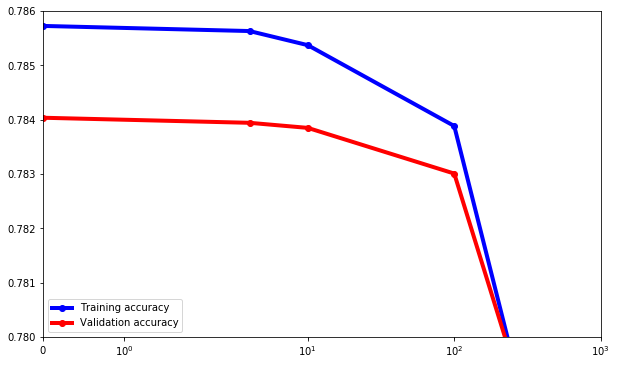

In [64]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?<br> L2 = 0
* **Quiz Question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data? <br> L2 = 0
* **Quiz Question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?<br>
No
